In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.collections import LineCollection
from scipy.interpolate import interp1d
import matplotlib.patches as mpatches

import matplotlib.colors as colors

In [2]:
from tphenotype import LaplaceEncoder, Predictor
from tphenotype.baselines import E2P, KME2P, KMDTW
from tphenotype.utils import get_auc_scores, get_cls_scores, select_by_steps, get_one_hot, data_split
from tphenotype.utils.dataset import cut_windowed_data

In [3]:
import sys
import os
import pickle
sys.path.append('../benchmark')

In [4]:
from benchmark import KME2P_config, Predictor_config, Encoder_config, Cls_config, loss_weights, batch_interp

In [5]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [6]:
dataname = 'ADNI'
with open(f'../benchmark/data/{dataname}_data.pkl', 'rb') as file:
    splits = pickle.load(file)

data_idx = 0
print(dataname)
train_set,valid_set,test_set = splits[data_idx]
print(f"total samples: {len(train_set['x'])+len(valid_set['x'])+len(test_set['x'])}")
_, T, x_dim = train_set['x'].shape
_, _, y_dim = train_set['y'].shape
print(f'max length: {T}')
print(f'x_dim: {x_dim}')
print(f'y_dim: {y_dim}')

feat_list = np.array(['APOE4','CDRSB','Hippocampus'])
temporal_dims = [1,2]


print(f'features: {feat_list}')
print(f'temporal dims: {temporal_dims}')

ADNI
total samples: 1346
max length: 12
x_dim: 3
y_dim: 3
features: ['APOE4' 'CDRSB' 'Hippocampus']
temporal dims: [1, 2]


In [7]:
K=4

KME2P_y_config = KME2P_config.copy()
KME2P_y_config['K'] = K
KME2P_y_config['x_dim'] = x_dim
KME2P_y_config['y_dim'] = y_dim
KME2P_y_config['latent_space'] = 'y'
KME2P_y_config['num_layers'] = 2
KME2P_y_config['hidden_size'] = 5

KME2P_z_config = KME2P_y_config.copy()
KME2P_z_config['latent_space'] = 'z'
KME2P_y_config['num_layers'] = 3
KME2P_y_config['hidden_size'] = 20
KME2P_y_config['latent_size'] = 10

KMDTW_config = {'K':K}

encoder_config = Encoder_config.copy()
encoder_config['pole_separation']=2.0
encoder_config['max_degree']=1

cls_config = Cls_config.copy()
cls_config['K'] = K
cls_config['steps'] = [-1]
predictor_config = Predictor_config.copy()
predictor_config['x_dim'] = x_dim
predictor_config['y_dim'] = y_dim
predictor_config['time_series_dims'] = temporal_dims
predictor_config['cls_config'] = cls_config
predictor_config['encoder_config'] = encoder_config
predictor_config['num_layer'] = 2
predictor_config['hidden_size'] = 10

loss_weights = {
    'ce': 1.0,
    'rmse': 1.0,
    'cont':0.01,
    'pole': 1.0,
    'real': 0.1
}
# for experiment results in paper, seed=13
seed=13

In [8]:
torch.random.manual_seed(seed)
TPhenotype = Predictor(**predictor_config)
TPhenotype = TPhenotype.fit(train_set, loss_weights,valid_set=valid_set,epochs=50, tolerance=None)

stage 1 - fit the Laplace Encoder 1/2


  0%|          | 0/50 [00:00<?, ?it/s]

stage 1 - fit the Laplace Encoder 2/2


  0%|          | 0/50 [00:00<?, ?it/s]

stage 2 - fit the predictor


  0%|          | 0/50 [00:00<?, ?it/s]

stage 3 - clustering on similarity graph
construct similarity graph


  0%|          | 0/616 [00:00<?, ?it/s]

discover clusters from similarity graph
done


In [9]:
torch.random.manual_seed(seed)
kme2py = KME2P(**KME2P_y_config)
kme2py = kme2py.fit(train_set, loss_weights,valid_set=valid_set,epochs=50, tolerance=None)

  0%|          | 0/50 [00:00<?, ?it/s]

In [10]:
x = test_set['x']
x_orig = test_set['x_orig']
t = test_set['t']
y = test_set['y']
y_label = np.argmax(y,axis=-1).astype('float')
mask = test_set['mask']
range_mask = test_set['range_mask']

In [11]:
steps=[-1]
feat = 'CDRSB'#'MMSE', 'Hippocampus', 'ADAS13', 'RAVLT_perc_forgetting'
[dim], = np.where(feat_list==feat)
x_sel = select_by_steps(x_orig, mask, steps,sub_sequence=True)
t_sel = select_by_steps(t, mask, steps,sub_sequence=True)
t_max = np.max(t_sel,axis=-1)
t_sel = t_sel - t_max[:,None] +np.max(t_max)
f_sel = x_sel[:,:,dim]
y_true = select_by_steps(y_label, mask,steps)


In [12]:
t_scale = 5.5

In [13]:
valid_points = range_mask.sum(axis=-1).astype(int)
for i,n in enumerate(valid_points):
    f_sel[i,:-n] = np.nan

In [14]:
steps =[-1]
y_pred_g = TPhenotype.predict_proba_g(x,t)
y_pred_g = select_by_steps(y_pred_g, mask,steps)
y_pred_TPhenotype = TPhenotype.predict_proba(x,t,mask, steps)
c_pred_TPhenotype = TPhenotype.predict_cluster(x,t,mask, steps)

In [15]:
steps =[-1]
y_pred_KME2P = kme2py.predict_proba(x,t)
y_pred_KME2P = select_by_steps(y_pred_KME2P, mask,steps)

c_pred_KME2P = kme2py.predict_cluster(x,t)
c_pred_KME2P = select_by_steps(c_pred_KME2P, mask,steps)

In [16]:
def plot_pattern(t_sel, f_sel, c_pred, y_true, y_pred,feat,label_list):
    Ks = np.unique(c_pred)
    K = len(Ks)
    fig, axs = plt.subplots(nrows=1, ncols=K, figsize=(4*K,4),sharex=True,  sharey=True)
    
    probs = []
    for k in Ks:
        probs.append(y_pred[c_pred==k][0][0])
    
    idx = np.argsort(probs)
    
    for l,k in enumerate(Ks[idx]):
        ax = axs[l]
        idx, = np.where(c_pred==k)
        x1 = f_sel[idx]
        t1 = t_sel[idx]*t_scale
        line_segments = LineCollection([np.column_stack([ti, xi]) for ti,xi in zip(t1, x1)], color='orange',alpha=0.2, linewidth=2,label='Sample')
        ax.add_collection(line_segments)
        #ax.scatter(t1[:,0],x1[:,0], color='darkorange',s=10,marker='o')
        t_sync = np.linspace(0,1*t_scale,num=100)
        x1_interp=batch_interp(t_sync,t1,x1)
        x1_mean= np.nanmean(x1_interp,axis=0)
        ax.plot(t_sync, x1_mean, color='red', linestyle='dashed',linewidth=4, label='Mean')
        ax.set_ylim([-1,np.nanmax(f_sel)+1])
        ax.set_xlim([-0.03*t_scale,1.03*t_scale])
        ax.set_xlabel('Year')
        ax.set_ylabel(feat)
        #ax.legend()
        m = c_pred==k
        vals, count = np.unique(y_true[m],return_counts=True)
        probs = y_pred[m][0]
        text = ''
        for j,outcome in enumerate(label_list):
            i, = np.where(vals == j)
            if len(i)==1:
                i=i[0]
                num = count[i]
            elif len(i)==0:
                num = 0
            else:
                raise AssertionError('this should not happen.')
            text += f'{outcome}: {num}'
            if j < len(label_list)-1:
                text+='\n'
  
        # for i,val in enumerate(vals):
        #     idx = int(val)
        #     outcome = label_list[idx]
        #     num = count[i]
        #     text += f'{outcome}: {num}'
        #     if i<len(vals)-1:
        #         text+='\n'

        ax.text(0.4*t_scale,17.2,text,va='top',ha='left',bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round'))
        msg =  f'Phenotype {l+1} ' + ','.join([f'p[{diag}]={p:.2f}'for diag, p in zip(['D','M','N'],probs)])
        print(msg)
        
        # this is an inset axes over the main axes
        inset_ax = ax.inset_axes([0.1, 0.55, .2, .15])
        inset_ax.set_ylim([0,1])
        #right_inset_ax.set(title='Probability', xticks=[], yticks=[])
        pd.Series(probs,index=label_list).plot(kind='bar', rot=90,ax=inset_ax)
        ax.legend(loc='upper left')
        ax.set_title(f'Phenotype {l+1}')
    fig.tight_layout()
    return fig

In [17]:
label_list = np.array(['AD','MCI','NL'])

Phenotype 1 p[D]=0.00,p[M]=0.15,p[N]=0.84
Phenotype 2 p[D]=0.03,p[M]=0.61,p[N]=0.37
Phenotype 3 p[D]=0.17,p[M]=0.81,p[N]=0.02
Phenotype 4 p[D]=0.63,p[M]=0.37,p[N]=0.00


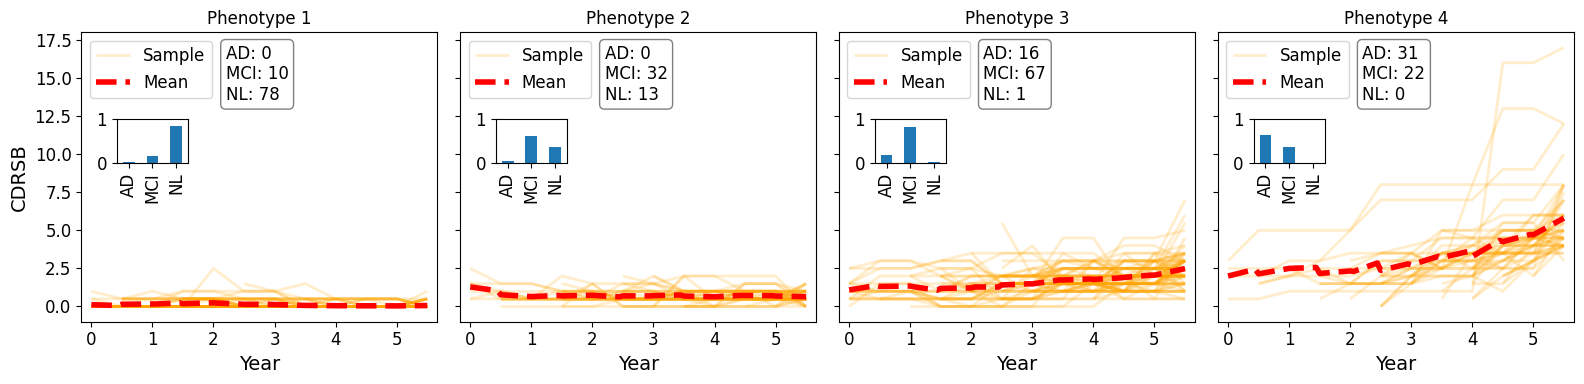

In [18]:
c_pred = c_pred_TPhenotype
y_pred = y_pred_TPhenotype
fig = plot_pattern(t_sel, f_sel, c_pred, y_true, y_pred,feat,label_list)
os.makedirs('figures', exist_ok=True)
fig.savefig('figures/ADNI_TPhenotype.pdf')

Phenotype 1 p[D]=0.00,p[M]=0.05,p[N]=0.95
Phenotype 2 p[D]=0.01,p[M]=0.77,p[N]=0.22
Phenotype 3 p[D]=0.59,p[M]=0.41,p[N]=0.00


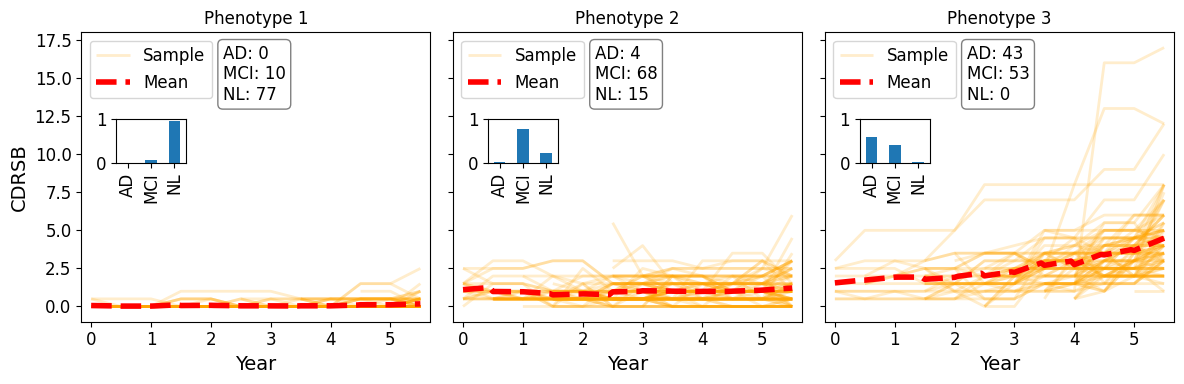

In [19]:
ADNI_preds = '../benchmark/external/ACTPC/output/ADNI_preds.pkl'

with open(ADNI_preds, 'rb') as file:
    model_preds = pickle.load(file)
    c_pred_ADNI = model_preds[data_idx]['c_pred']
    y_pred_ADNI = model_preds[data_idx]['y_pred']
    c_pred = select_by_steps(c_pred_ADNI,mask,steps)
    y_pred = select_by_steps(y_pred_ADNI,mask,steps)
fig = plot_pattern(t_sel, f_sel, c_pred, y_true, y_pred,feat,label_list)
os.makedirs('figures', exist_ok=True)
fig.savefig('figures/ADNI_AC_TPC.pdf')

Phenotype 1 p[D]=0.00,p[M]=0.17,p[N]=0.83
Phenotype 2 p[D]=0.04,p[M]=0.81,p[N]=0.15
Phenotype 3 p[D]=0.38,p[M]=0.60,p[N]=0.02
Phenotype 4 p[D]=0.42,p[M]=0.56,p[N]=0.02


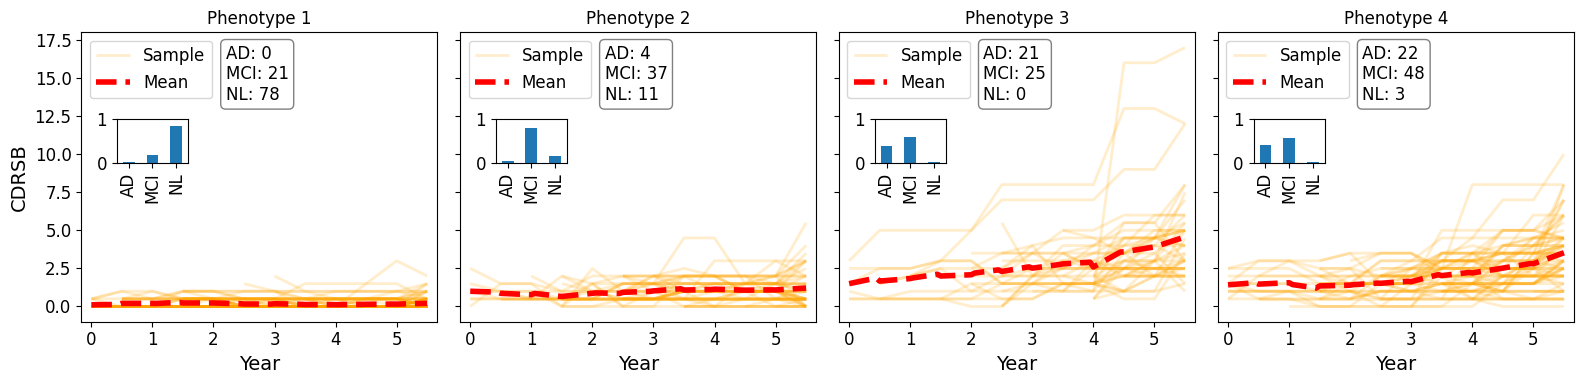

In [20]:
S2S_preds = '../benchmark/external/dcn_Seq2Seq/output/ADNI_preds.pkl'

with open(S2S_preds, 'rb') as file:
    model_preds = pickle.load(file)
    c_pred_S2S = model_preds[0]['c_pred']
    y_pred_S2S = model_preds[0]['y_pred']
    c_pred = select_by_steps(c_pred_S2S,mask,steps=[-1])
    y_pred = select_by_steps(y_pred_S2S,mask,steps=[-1])
fig=plot_pattern(t_sel, f_sel, c_pred, y_true, y_pred,feat,label_list)
fig.savefig('figures/ADNI_S2S.pdf')

Phenotype 1 p[D]=0.00,p[M]=0.03,p[N]=0.97
Phenotype 2 p[D]=0.01,p[M]=0.69,p[N]=0.30
Phenotype 3 p[D]=0.15,p[M]=0.75,p[N]=0.10
Phenotype 4 p[D]=0.54,p[M]=0.44,p[N]=0.02


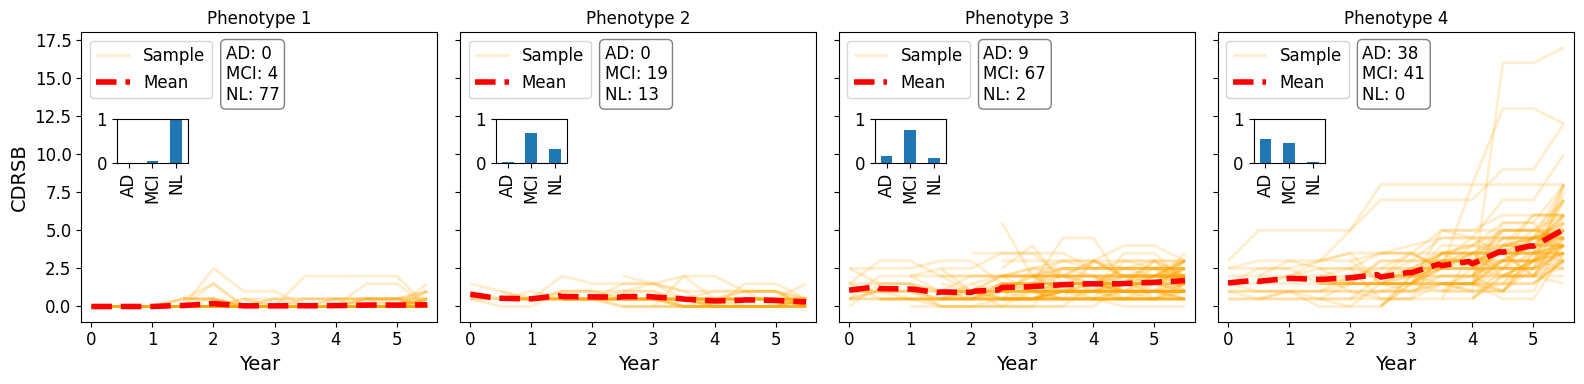

In [21]:
c_pred = c_pred_KME2P
y_pred = y_pred_KME2P
fig = plot_pattern(t_sel, f_sel, c_pred, y_true, y_pred,feat,label_list)
#os.makedirs('figures', exist_ok=True)
fig.savefig('figures/ADNI_KME2Py.pdf')

### Case study

In [22]:
x = test_set['x']
x_orig = test_set['x_orig']
t = test_set['t']
y = test_set['y']
y_label = np.argmax(y,axis=-1).astype('float')
mask = test_set['mask']
range_mask = test_set['range_mask']
#y_label[mask==0]=np.nan

In [23]:
np.where(np.any(range_mask*(y_label==0),axis=-1)*np.any(range_mask*(y_label==1),axis=-1)*(range_mask.sum(axis=-1)>7))

(array([  9,  10,  11,  12,  63,  75, 108, 120, 144, 182, 205, 221, 238,
        243, 261]),)

In [24]:
i=221
y_label[i], mask[i], 

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32))

In [25]:
idx=[i] # possible options: 144, 205, 221, 238, 261
c_TPhenotype = TPhenotype.predict_cluster(x[idx],t[idx])
c_ADNI = c_pred_ADNI[idx]

In [26]:
c_TPhenotype, c_ADNI

(array([[0, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1]]),
 array([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]], dtype=int32))

In [27]:
feat = 'CDRSB'# 'CDRSB'#'MMSE', 'Hippocampus', 'ADAS13', 'RAVLT_perc_forgetting'
[dim], = np.where(feat_list==feat)
f = x_orig[idx][:,:,dim]
feat1 = 'Hippocampus'# 'CDRSB'#'MMSE', 'Hippocampus', 'ADAS13', 'RAVLT_perc_forgetting'
[dim], = np.where(feat_list==feat1)
f1 = x_orig[idx][:,:,dim]

In [28]:
x_orig[idx,0]

array([[1.000e+00, 2.000e+00, 5.873e+03]], dtype=float32)

In [29]:
c_TPhenotype = c_TPhenotype.astype('float32')
c_TPhenotype[range_mask[idx]==0]=np.nan
c_ADNI = c_ADNI.astype('float32')
c_ADNI[range_mask[idx]==0]=np.nan
f[range_mask[idx]==0]=np.nan
f1[range_mask[idx]==0]=np.nan

In [30]:
outcome = y_label[idx]

In [31]:
c_TPhenotype, c_ADNI, outcome

(array([[0., 3., 3., 3., 3., 3., 3., 3., 3., 1., 1., 1.]], dtype=float32),
 array([[2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]], dtype=float32),
 array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.]]))

In [32]:
y_min, y_max = np.min(f1[~np.isnan(f1)]), np.max(f1[~np.isnan(f1)])

In [33]:
c_TPhenotype[0,[0,7,11]]

array([0., 3., 1.], dtype=float32)

In [34]:
c_ADNI[0,[0,7,11]]

array([2., 2., 2.], dtype=float32)

Phenotype (model internal, not sorted by p(AD=1)) 1
Phenotype (model internal, not sorted by p(AD=1)) 4
Phenotype (model internal, not sorted by p(AD=1)) 2


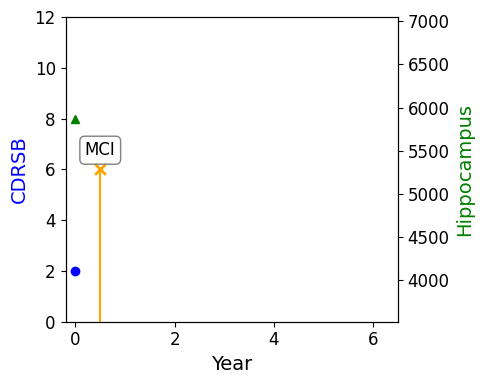

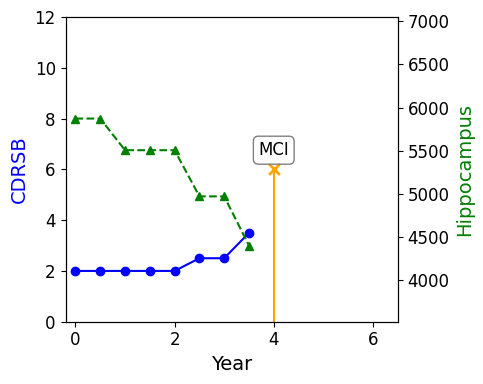

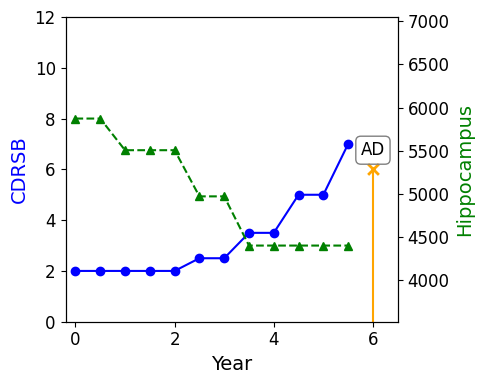

In [35]:
for step in [1,8,12]:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4), sharex=True, sharey=True)

    for tt,ff,ff1,cc in zip(t_scale*t[idx], f,f1, c_TPhenotype):
        ax.plot(tt[:step],ff[:step], marker='o',color='blue')
        ax1 = ax.twinx()
        ax1.plot(tt[:step],ff1[:step],linestyle='dashed', marker='^',color='green')
        ax1.set_ylim([y_min*0.8, y_max*1.2])
        ax1.set_ylabel(feat1,color='green')

        ax.vlines(tt[step-1]+0.5,0,6,color='orange')
        ax.scatter(tt[step-1]+0.5,6,marker='x',color='orange',s=60,linewidth=2)
        text = f'{label_list[int(outcome[0,step-1])]}'
        print(f'Phenotype (model internal, not sorted by p(AD=1)) {c_TPhenotype[0,step-1]+1:.0f}')
        ax.text(tt[step-1]+0.5,6.4,text, va='bottom', ha='center',bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round'))
        ax.set_ylim([0,12])
        ax.set_xlim([-0.2,t_scale+1])
        ax.set_ylabel(feat,color='blue')
        ax.set_xlabel('Year')
    fig.tight_layout()
    fig.savefig(f'figures/ADNI_traj_{step}.pdf')

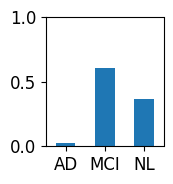

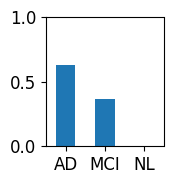

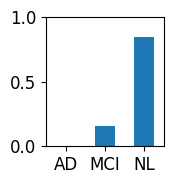

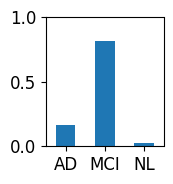

In [36]:
probs=np.zeros((K,y_dim))
for k in range(K):
    probs[k] = TPhenotype.cls.kmeans.get_cluster(k)['p']
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2, 2), sharex=True, sharey=True)
    pd.Series(probs[k],index=label_list).plot(kind='bar', rot=0,ax=ax)
    ax.set_ylim([0,1])
    fig.tight_layout()
    fig.savefig(f'figures/TPhenotype_C_{k+1}.pdf')

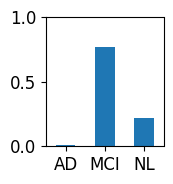

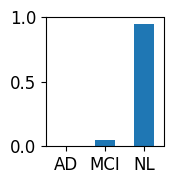

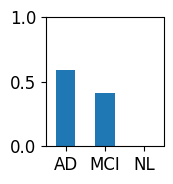

In [37]:
probs=np.zeros((K,y_dim))
for k in range(K):
    probs_k = select_by_steps(y_pred_ADNI,mask,steps)[select_by_steps(c_pred_ADNI,mask,steps)==k]
    if len(probs_k)>0:
        probs[k] = probs_k[0]
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2, 2), sharex=True, sharey=True)
        pd.Series(probs[k],index=label_list).plot(kind='bar', rot=0,ax=ax)
        ax.set_ylim([0,1])
        fig.tight_layout()
        fig.savefig(f'figures/ACTPC_C_{k+1}.pdf')
